#### Importing the Required Python libraries 

In [1]:
import glob
import pandas as pd
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier , ExtraTreesClassifier , RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
import time
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.target import ClassBalance
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.classifier import ClassPredictionError,ConfusionMatrix,ROCAUC,ClassificationReport
from yellowbrick.model_selection import CVScores

#### OCR output in individual csv files is pre-processed to remove the common stop words and concatenated to a single file

In [2]:

stop_words = ['a','about','above','after','again','against','all','am','an','and','any','are',"aren't",'as','at',
 'be','because','been','before','being','below','between','both','but','by',"can't",'cannot',
 'could',"couldn't",'did',"didn't",'do','does',"doesn't",'doing',"don't",'down','during','each','few','for',
 'from','further','had',"hadn't",'has',"hasn't",'have',"haven't",'having','he',"he'd","he'll","he's",'her','here',
 "here's",'hers','herself','him','himself','his','how',"how's",'i',"i'd","i'll","i'm","i've",'if','in','into',
 'is',"isn't",'it',"it's",'its','itself',"let's",'me','more','most',"mustn't",'my','myself','no','nor','not',
 'of','off','once','only', 'or','other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same',
 "shan't",'she', "she'd","she'll", "she's", 'should', "shouldn't", 'so', 'some','such','than',
 'that',"that's",'the','their','theirs','them','themselves','then','there',"there's",'these','they',
 "they'd","they'll","they're","they've",'this','those', 'through','to','too','under','until','up',
 'very','was',"wasn't",'we',"we'd","we'll","we're","we've",'were',"weren't",'what',"what's",'when',"when's",
 'where',"where's",'which','while','who',"who's",'whom','why',"why's",'with',"won't",'would',
 "wouldn't",'you',"you'd","you'll", "you're","you've",'your','yours','yourself','yourselves','ee','oo','oe','ae',
  'es','eee','es','ss','os','se','al','te','pe','fe','mr','dr','ge','et',
             'et','ce','ne','ss','ay','ot','fe','bs','le','eo','ey','fo',
             'en', 'gs', 'er','ea','eae','ing', 'tt', 'nn','ao','aa']

In [3]:
csvs = glob.glob('./stage/tesseractoutput/*.csv')
df = pd.read_csv(csvs[0])[['text','label']].dropna()
for csv in csvs[1:]:
    print(csv)
    new_df=pd.read_csv(csv)[['text','label']].dropna()
    df = df.append(new_df)
df['text'] = df['text'].apply(lambda x:  ' '.join(i for i in x.lower().split() if i not in stop_words))
df.to_csv('data_total.csv',index=False,mode='w+')

./stage/tesseractoutput\Email.csv
./stage/tesseractoutput\Form.csv
./stage/tesseractoutput\Letter.csv
./stage/tesseractoutput\Memo.csv
./stage/tesseractoutput\News.csv
./stage/tesseractoutput\Note.csv
./stage/tesseractoutput\Report.csv
./stage/tesseractoutput\Resume.csv
./stage/tesseractoutput\Scientific.csv


#### Document labels are encoded, a dictionary is created with label name and document count for each label 

In [4]:
def prep_data_file(file_name,column):
    """
    input: pandas df
    output: cleaned text column , label dict
    """

    data = pd.read_csv(file_name).dropna()
    le = LabelEncoder()
    le.fit(data[column])
    labels = le.transform(data[column])
        
    label_dict = {}

    for name, label in zip(data[column],labels):
        label_dict[label] = name

    return label_dict, labels, data

In [5]:
label_dict, labels, data=prep_data_file('data_total.csv','label')
label_dict , Counter(data['label'])

({0: 'ADVE',
  1: 'Email',
  2: 'Form',
  3: 'Letter',
  4: 'Memo',
  5: 'News',
  6: 'Note',
  7: 'Report',
  8: 'Resume',
  9: 'Scientific'},
 Counter({'ADVE': 222,
          'Email': 599,
          'Form': 431,
          'Letter': 567,
          'Memo': 620,
          'News': 188,
          'Note': 185,
          'Report': 265,
          'Resume': 120,
          'Scientific': 261}))

#### 1)Top 25 words Frequency visualization of different document categories 


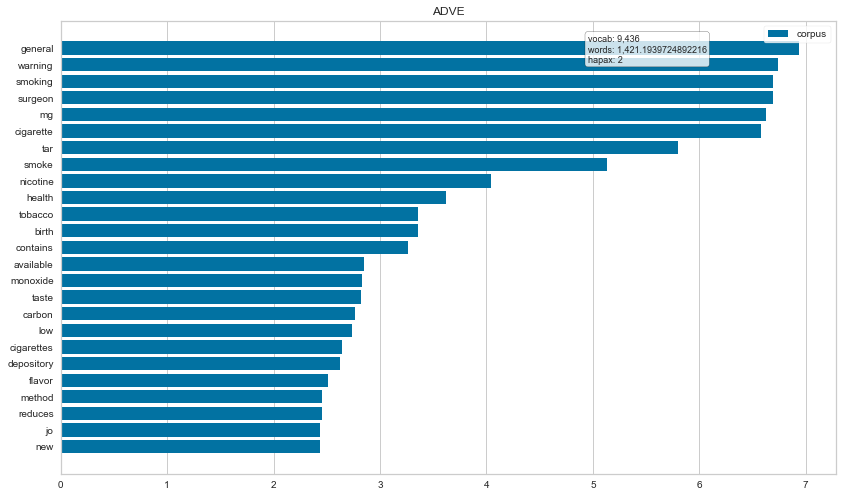

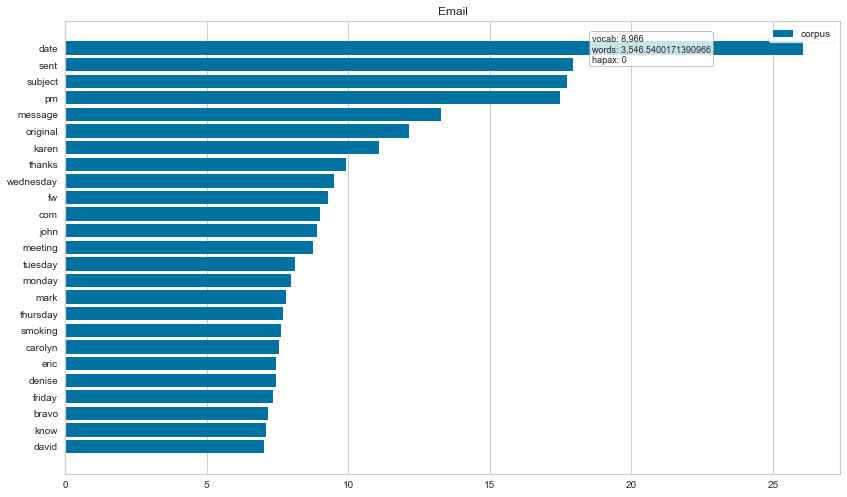

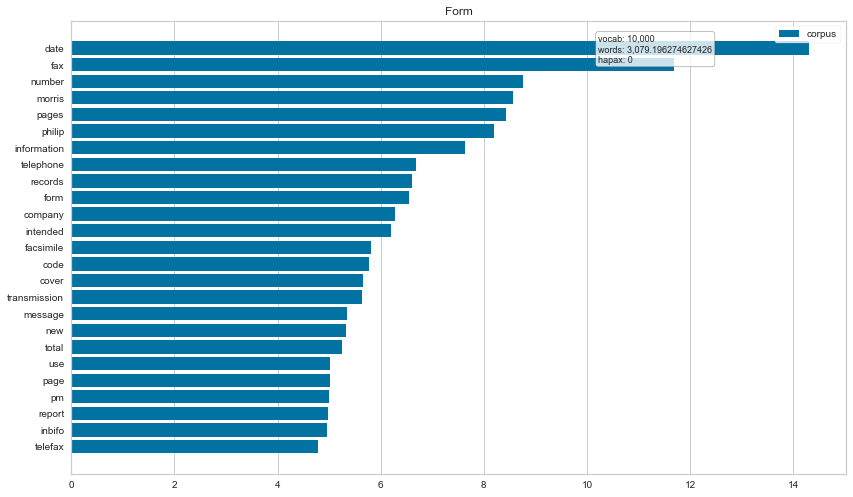

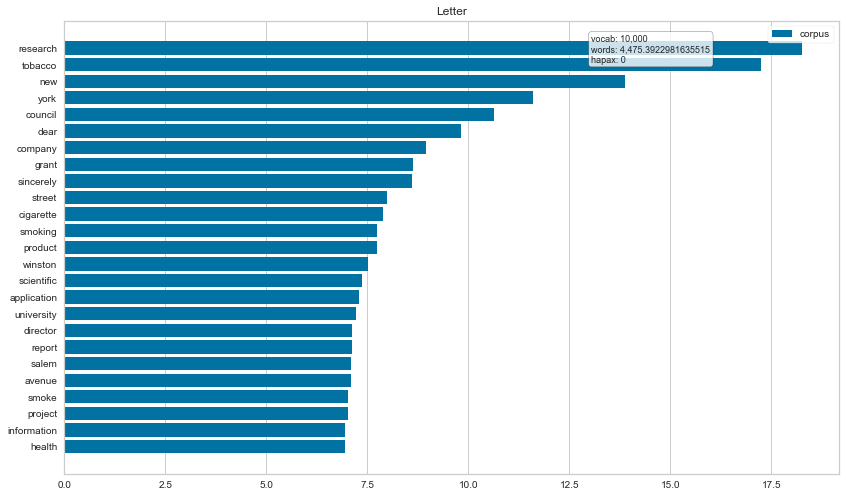

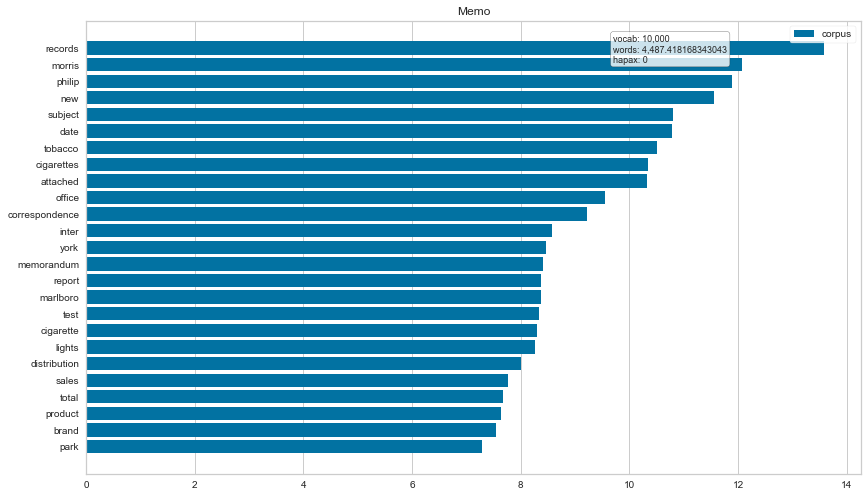

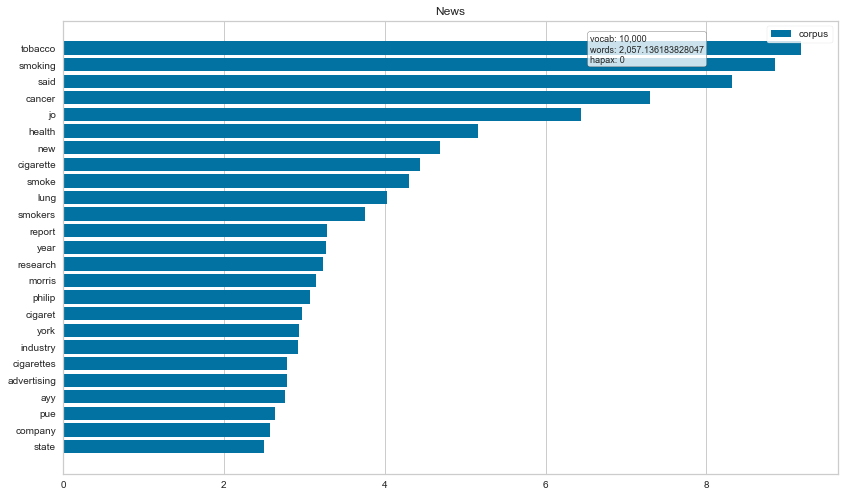

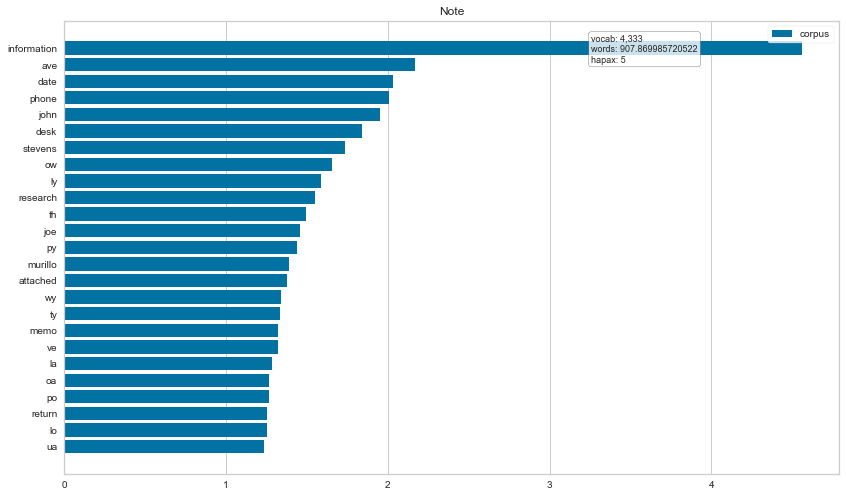

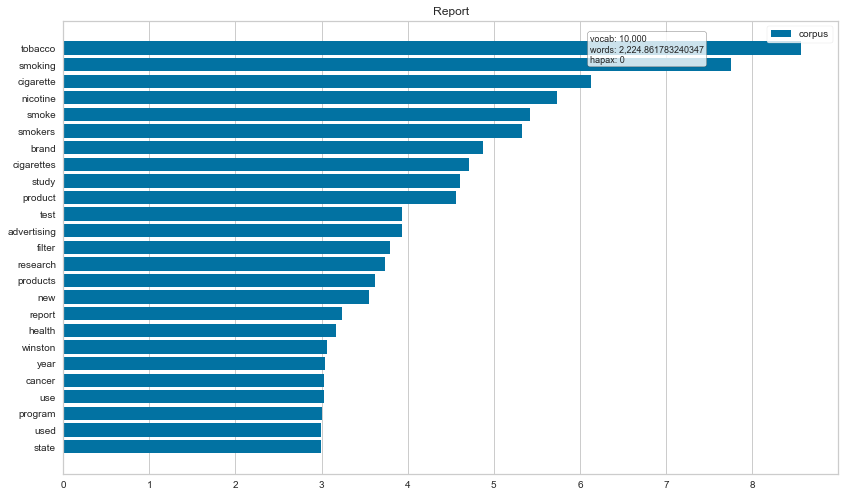

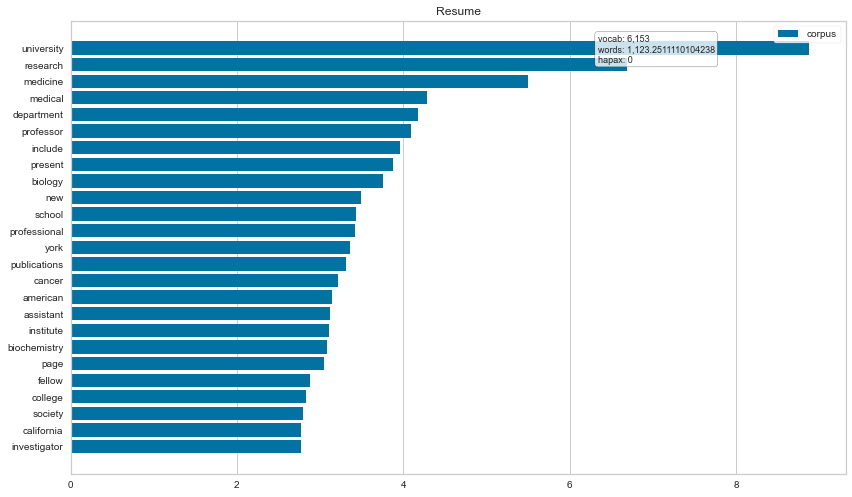

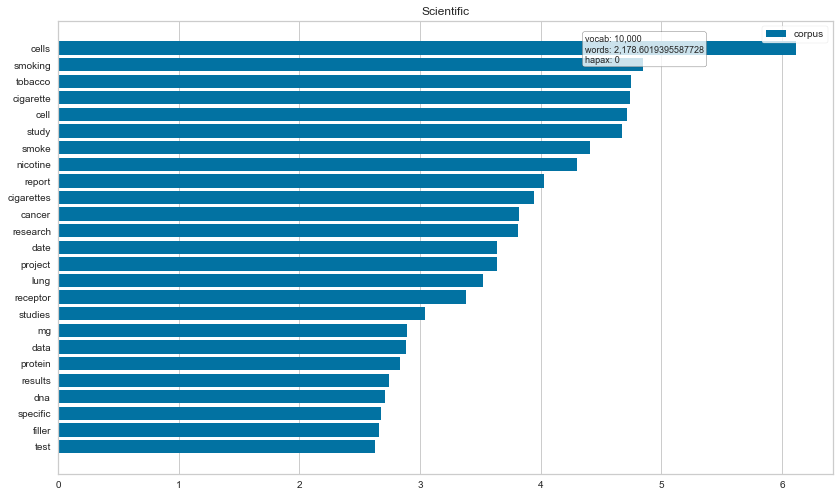

In [6]:
for l in label_dict.values():

    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words = "english", lowercase = True, max_features = 10000)
    docs       = vectorizer.fit_transform(data[data['label']==l]['text'])
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(title = l ,features=features, orient='h',size=(1000, 600), n = 25)
    visualizer.fit(docs)
    visualizer.show()

####  2) UMAP visualization


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

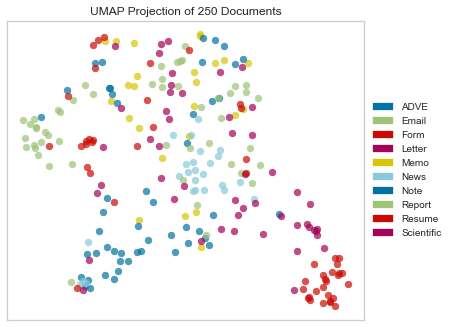

In [7]:
from yellowbrick.text import UMAPVisualizer
from sklearn.utils import resample
n=list(set(data['label']))
 
base = resample(data[data['label']==n[0]],replace=False,n_samples=25)
    
for sel_label in n[1:]:
    df_1 = resample(data[data['label']==sel_label],replace=False,n_samples=25)
    base = base.append(df_1)

tfidf = TfidfVectorizer()
docs1 = tfidf.fit_transform(base['text'])
labels1 = base['label']
# Instantiate the text visualizer
umap = UMAPVisualizer()
umap.fit(docs1, labels1)
umap.show()

####  3) Document Similarity HeatMap

In [9]:

def show_similarity(data,col):
    from matplotlib import pyplot as plt
    new_sample=resample(data[data['label']==col]['text'],replace=False,n_samples=15)
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words = "english", lowercase = True, max_features = 10000)
    docs       = vectorizer.fit_transform(new_sample).toarray()
    corr = np.inner(docs, docs)
    print("mean similarity",np.mean(corr))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
          corr,
          vmin=0,
          vmax=1,
          cmap="YlOrRd")
    title ="Semantic Textual Similarity of "+col
    g.set_title(title)


mean similarity 0.08605749512877474


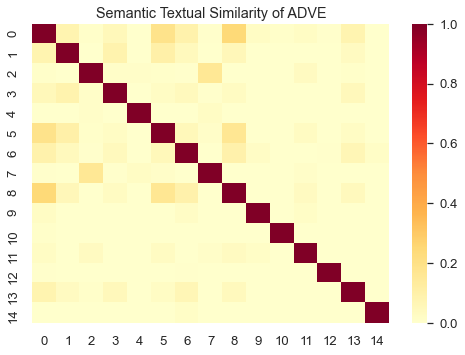

In [10]:

show_similarity(data,'ADVE')

mean similarity 0.09817386264436627


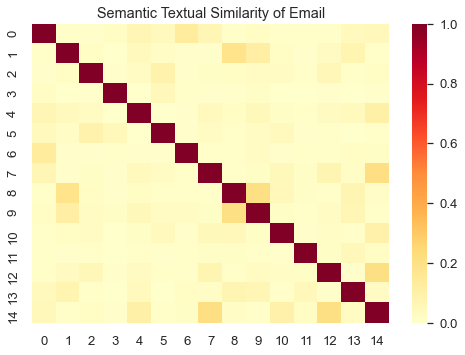

In [11]:
show_similarity(data,'Email')

mean similarity 0.08476822677305977


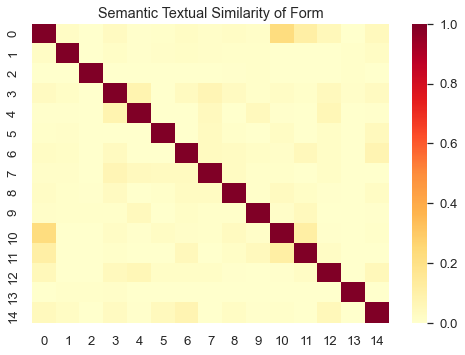

In [12]:
show_similarity(data,'Form')

mean similarity 0.08570284661765895


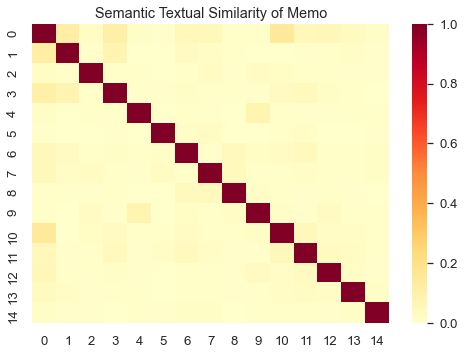

In [13]:
show_similarity(data,'Memo')

mean similarity 0.1051427753164055


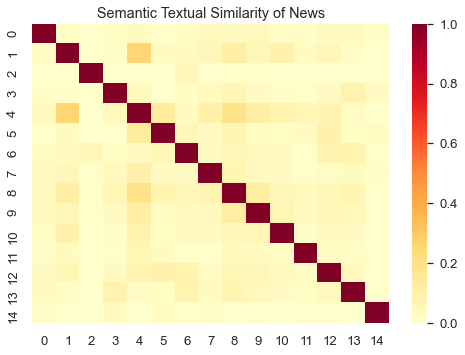

In [14]:
show_similarity(data,'News')

mean similarity 0.07732602589849585


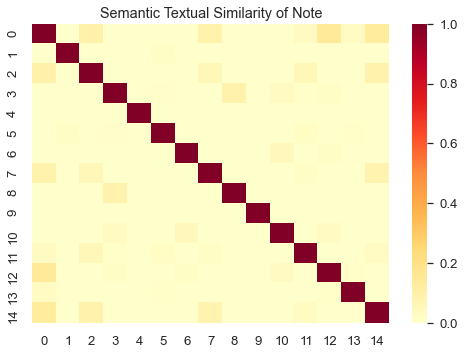

In [15]:
show_similarity(data,'Note')

mean similarity 0.09088922449081432


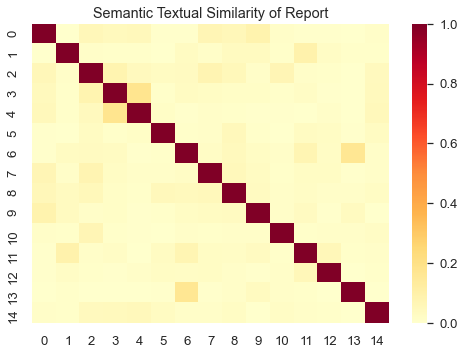

In [16]:
show_similarity(data,'Report')

mean similarity 0.13118906766537128


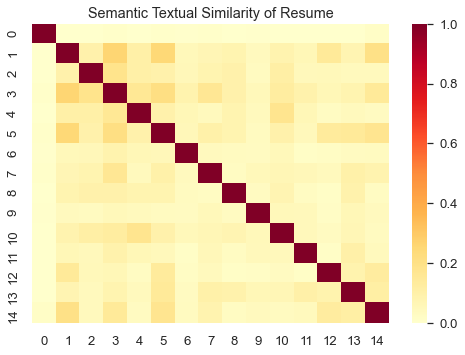

In [17]:
show_similarity(data,'Resume')

mean similarity 0.09065379947301895


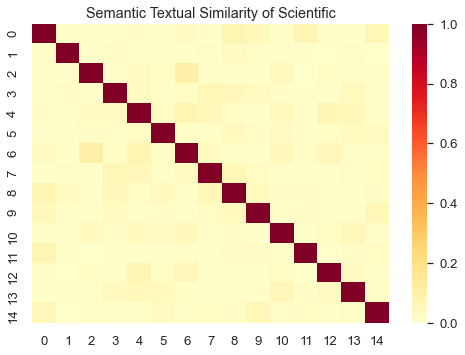

In [18]:
show_similarity(data,'Scientific')

####  Vectorization of input text and train test data creation 

In [19]:
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,1))

X, y = vectorizer.fit_transform(data['text']), list(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Distribution of Training and Test Data in each document category

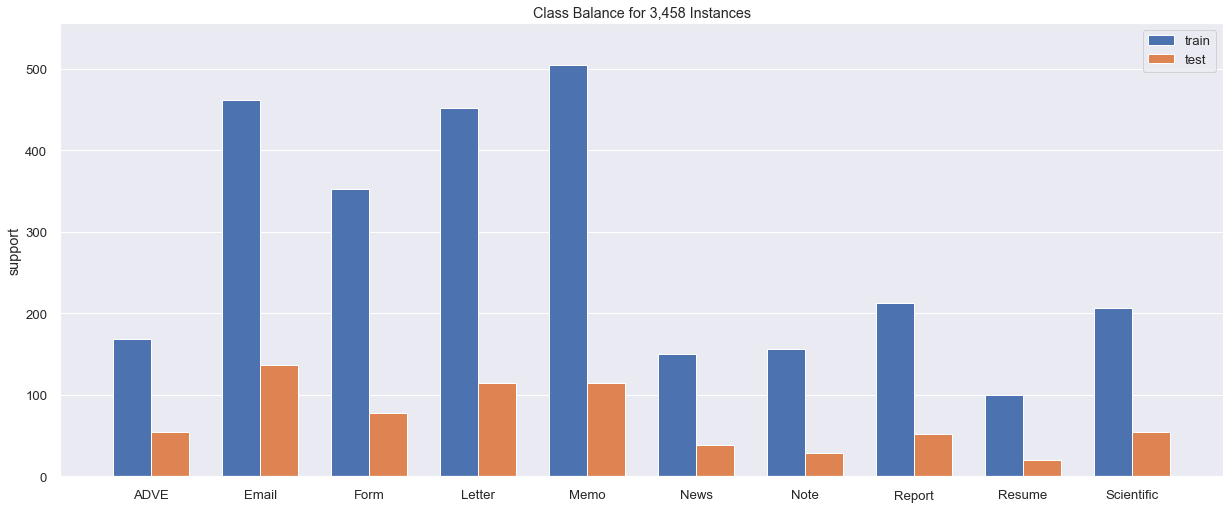

In [20]:
#identifying class balance between test and train datasets in each document category
names = [label_dict[i] for i in sorted(label_dict.keys())]
visualizer = ClassBalance(labels=names,size =(1500,600))
visualizer.fit(np.asarray(y_train), np.asarray(y_test))
visualizer.show()

#### Model Building and Model Evaluation.

In [21]:
def model_testing(X_train, X_test, y_train, y_test):
    # creates a list of models and calls the score function to fit the model against the training 
    # data and validate against test data and store the
    # model evaluation results in an array

    models = [
        MultinomialNB(),
        SGDClassifier(n_jobs=-1), 
        BaggingClassifier(n_jobs=-1,random_state = 42),
        ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state =0),   
        RandomForestClassifier(n_estimators=300, n_jobs=-1,random_state = 0),
        AdaBoostClassifier(random_state = 0)
    ]

    model_name = []
    avg_abs_err = []
    accuracy = []
    recall = []
    precision = []
    f1 = []
    time_to_train = []

    for model in models:
        model_name_,avg_error,accuracy_,recall_,precision_,f1_,speed_ = score(X_train, X_test, y_train, y_test, model)
        model_name.append(model_name_.split('(')[0])
        avg_abs_err.append(avg_error)
        accuracy.append(accuracy_)
        recall.append(recall_)
        precision.append(precision_)
        f1.append(f1_)
        time_to_train.append(speed_)

    results = pd.DataFrame(columns = [])
    results['model_name'] = model_name
    results['accuracy'] = accuracy
    results['abs_error'] = avg_abs_err
    results['recall'] = recall
    results['precision'] = precision 
    results['f1'] = f1
    results['Training Speed(secs)'] = time_to_train

    return results

In [22]:
def score(X_train, X_test, y_train, y_test, estimator):
    # Fit X_train and y_train against the estimator and create evaluation metric
    model = estimator
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    speed = round(end-start,2)
    predicted = model.predict(X_test)
    abs_err = np.mean(np.abs(predicted - y_test))
    name = str(estimator)
    f1score = f1_score(y_test,predicted,average='macro')
    recall = recall_score(y_test, predicted,average='macro')
    precision = precision_score(y_test, predicted,average='macro')
    accuracy = accuracy_score(y_test, predicted)
    return name,abs_err,accuracy,recall,precision,f1score,speed

In [23]:
X_train.shape , X_test.shape

((2766, 71006), (692, 71006))

In [24]:
results = model_testing(X_train, X_test, y_train, y_test)

C:\Users\baiju\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baiju\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
results

,model_name,accuracy,abs_error,recall,precision,f1,Training Speed(secs)
0,MultinomialNB,0.544798,1.372832,0.390340,0.528908,0.379483,0.02
1,SGDClassifier,0.796243,0.653179,0.765757,0.775783,0.764807,0.05
2,BaggingClassifier,0.739884,0.994220,0.694135,0.703997,0.695510,4.52
3,ExtraTreesClassifier,0.750000,0.882948,0.681310,0.767469,0.674245,9.16
4,RandomForestClassifier,0.770231,0.851156,0.705685,0.768116,0.709406,5.19
5,AdaBoostClassifier,0.475434,1.708092,0.374198,0.395549,0.344225,12.96


#### Building and Evaluating the LSTM model

In [26]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each Text.
MAX_SEQUENCE_LENGTH = 250 # try changing
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words =MAX_NB_WORDS)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
X1 = tokenizer.texts_to_sequences(data['text'].values)
X1 = pad_sequences(X1, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
Y1= pd.get_dummies(data['label']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, test_size=0.25, random_state=45)


In [28]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 71006, 100)        5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 5,181,910
Trainable params: 5,181,910
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
epochs = 5
batch_size = 10
start = time.time()
end = time.time()
speed = round(end-start,2)

history = model2.fit(X1_train, Y1_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0)])
end = time.time()
speed = round(end-start,2)

Epoch 1/5
234/234 [==============================] - 48s 137ms/step - loss: 1.8768 - accuracy: 0.3150 - val_loss: 1.0527 - val_accuracy: 0.6654
Epoch 2/5
234/234 [==============================] - 32s 135ms/step - loss: 0.8128 - accuracy: 0.7111 - val_loss: 0.8684 - val_accuracy: 0.7385
Epoch 3/5
234/234 [==============================] - 32s 137ms/step - loss: 0.3330 - accuracy: 0.8961 - val_loss: 0.8658 - val_accuracy: 0.7269
Epoch 4/5
234/234 [==============================] - 31s 134ms/step - loss: 0.1480 - accuracy: 0.9578 - val_loss: 0.9803 - val_accuracy: 0.7346
Epoch 5/5
234/234 [==============================] - 32s 137ms/step - loss: 0.1581 - accuracy: 0.9606 - val_loss: 1.2005 - val_accuracy: 0.6962


In [30]:
Y1_predict_test = model2.predict_classes(X1_test, verbose=0)


C:\Users\baiju\Anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
rounded_labels=np.argmax(Y1_test, axis=1)

In [32]:

accuracy = accuracy_score(rounded_labels, Y1_predict_test)
print('Accuracy: %f' % accuracy)
 
precision = precision_score(rounded_labels, Y1_predict_test,average='macro')
print('Precision: %f' % precision)
 
recall = recall_score(rounded_labels, Y1_predict_test,average='macro')
print('Recall: %f' % recall)
 
f1 = f1_score(rounded_labels, Y1_predict_test,average='macro')
print('F1 score: %f' % f1)

avg_abs_err = np.mean(np.abs(Y1_predict_test - rounded_labels))
print('Absolute Error: %f' % avg_abs_err)

Accuracy: 0.680925
Precision: 0.661590
Recall: 0.637325
F1 score: 0.635713
Absolute Error: 1.136416


In [33]:
df =pd.DataFrame(data ={'model_name':['LSTMClassifier'],
                 'accuracy':[accuracy],
                 'abs_error':[avg_abs_err],
                 'recall':[recall],
                 'precision':[precision],
                 'f1':[f1],
                 'Training Speed(secs)':[speed]})
results.append(df)

,model_name,accuracy,abs_error,recall,precision,f1,Training Speed(secs)
0,MultinomialNB,0.544798,1.372832,0.390340,0.528908,0.379483,0.02
1,SGDClassifier,0.796243,0.653179,0.765757,0.775783,0.764807,0.05
2,BaggingClassifier,0.739884,0.994220,0.694135,0.703997,0.695510,4.52
3,ExtraTreesClassifier,0.750000,0.882948,0.681310,0.767469,0.674245,9.16
4,RandomForestClassifier,0.770231,0.851156,0.705685,0.768116,0.709406,5.19
5,AdaBoostClassifier,0.475434,1.708092,0.374198,0.395549,0.344225,12.96
0,LSTMClassifier,0.680925,1.136416,0.637325,0.661590,0.635713,174.98


#### Final model selection. 

In [34]:
final_model = SGDClassifier(n_jobs=-1)


In [35]:
 
final_model.fit(X_train,y_train)
prediction = final_model.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score , f1_score, precision_score , recall_score
print(accuracy_score(y_test, prediction))
print(f1_score(y_test, prediction,average='macro'))
print(precision_score(y_test, prediction,average='macro'))
print(recall_score(y_test, prediction,average='macro'))

0.7933526011560693
0.7620708870693347
0.7740024822321491
0.7606141664860443


#### Final Model Performance Visualization

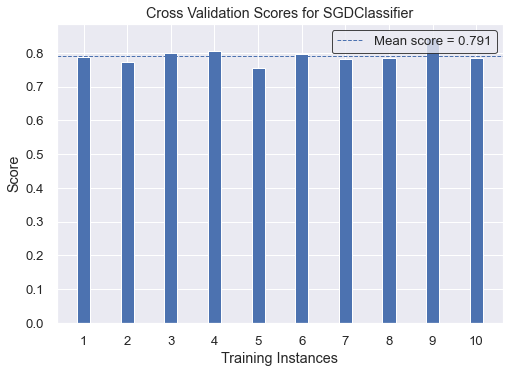

In [37]:
cv = StratifiedKFold(n_splits=10)
# Instantiate the classification model and visualizer
model = final_model 
visualizer = CVScores(model, cv=cv, scoring='f1_weighted')
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

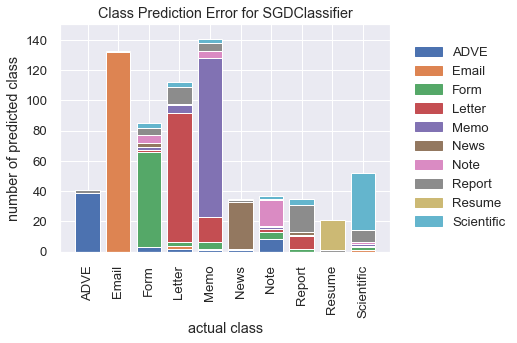

In [38]:
visualizer = ClassPredictionError(final_model, 
                                      cmap="YlGn",classes=names,size=(600, 360))
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
# Evaluate the model on the test data
visualizer.score(X_test, y_test)
# Draw visualization
visualizer.show()

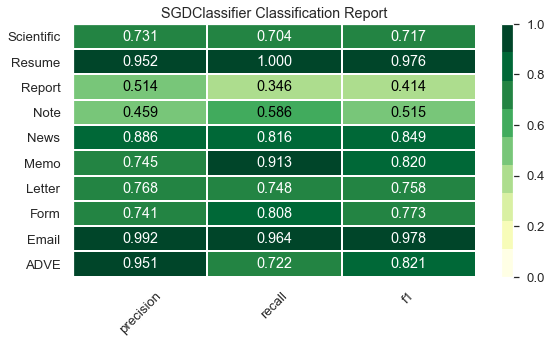

In [39]:
visualizer = ClassificationReport(model,cmap="YlGn", classes=names, size=(600, 360))
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.show()

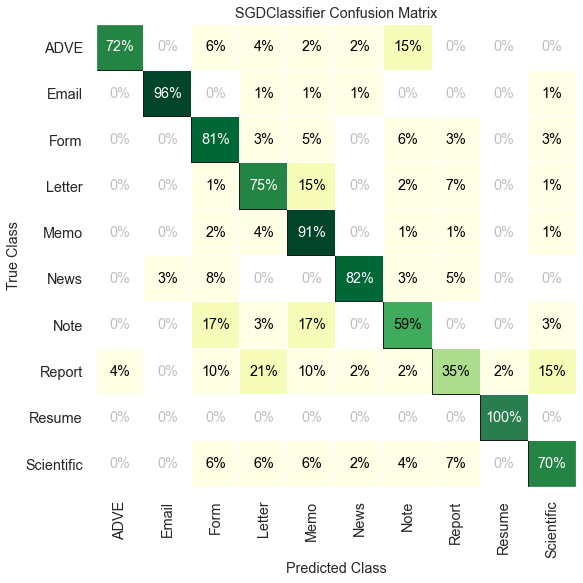

In [40]:
visualizer = ConfusionMatrix(final_model, cmap="YlGn",classes=names, size=(600, 600), percent=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()    


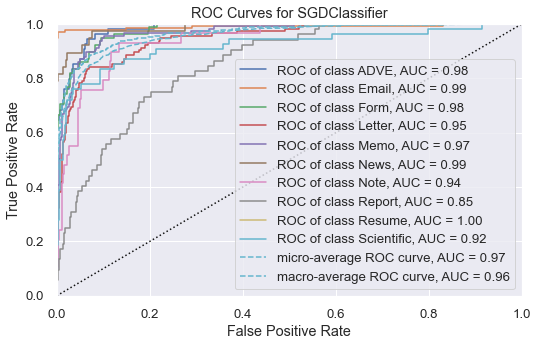

In [41]:
visualizer = ROCAUC(final_model, cmap="YlGn",classes=names, size=(600, 360))
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   
 